# 삼성 주가 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action = 'ignore')
dataset_path = os.getenv("HOME")+"/aiffel/stock_prediction/data/005930.KS.csv"
df = pd.read_csv(dataset_path, index_col = 'Date', parse_dates = True)
ts = df['Close']
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [2]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
#로그 변환
ts_log = np.log(ts)

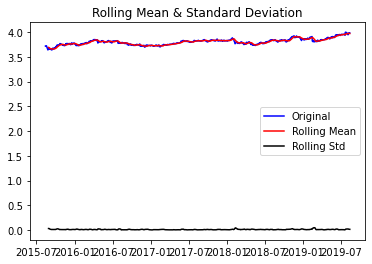

Results of Dickey-Fuller Test:
Test Statistic                   -1.379754
p-value                           0.591943
#Lags Used                        2.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


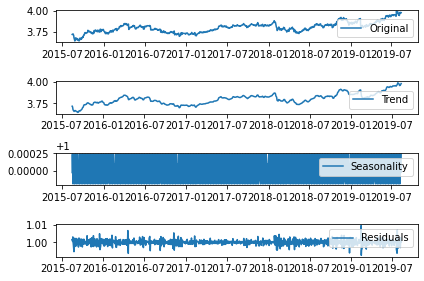

In [50]:
from statsmodels.tsa.stattools import adfuller
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [51]:
# Residual 안정성 확인
residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.239847e+01
p-value                        4.617886e-23
#Lags Used                     2.000000e+01
Number of Observations Used    9.820000e+02
Critical Value (1%)           -3.437027e+00
Critical Value (5%)           -2.864488e+00
Critical Value (10%)          -2.568340e+00
dtype: float64


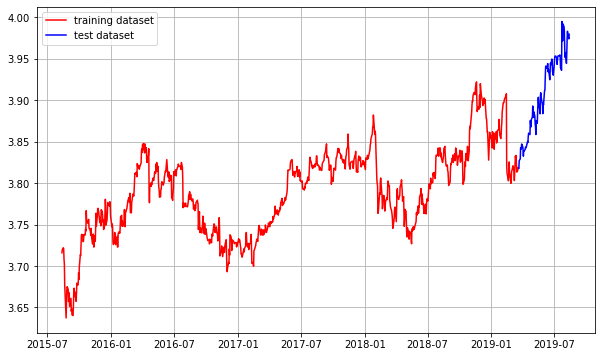

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')
plt.plot(test_data, c = 'b' ,label = 'test dataset')
plt.legend()

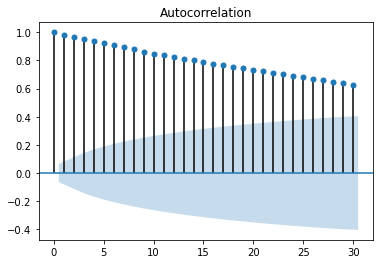

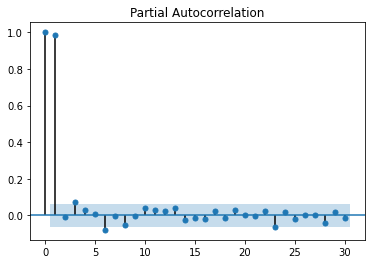

In [53]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_data)
plot_pacf(train_data)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -22.965435
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    903.000000
Critical Value (1%)             -3.437612
Critical Value (5%)             -2.864746
Critical Value (10%)            -2.568477
dtype: float64


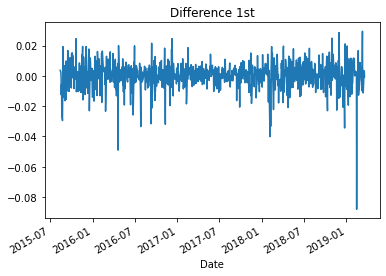

In [54]:
# 차분 안정성 확인 -> d 구하기
diff_1 = train_data.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.187679e+01
p-value                        6.313456e-22
#Lags Used                     2.000000e+01
Number of Observations Used    8.830000e+02
Critical Value (1%)           -3.437777e+00
Critical Value (5%)           -2.864819e+00
Critical Value (10%)          -2.568516e+00
dtype: float64


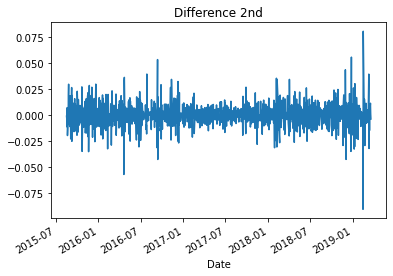

In [55]:
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [56]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1,1,0))
fit = model.fit(disp =-1)
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  905
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2966.704
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 13 Aug 2020   AIC                          -5927.409
Time:                        17:25:31   BIC                          -5912.985
Sample:                             1   HQIC                         -5921.900
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.372      0.710      -0.000       0.001
ar.L1.D.Close     0.0038      0.033      0.114      0.909      -0.061       0.069
                                    Root

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


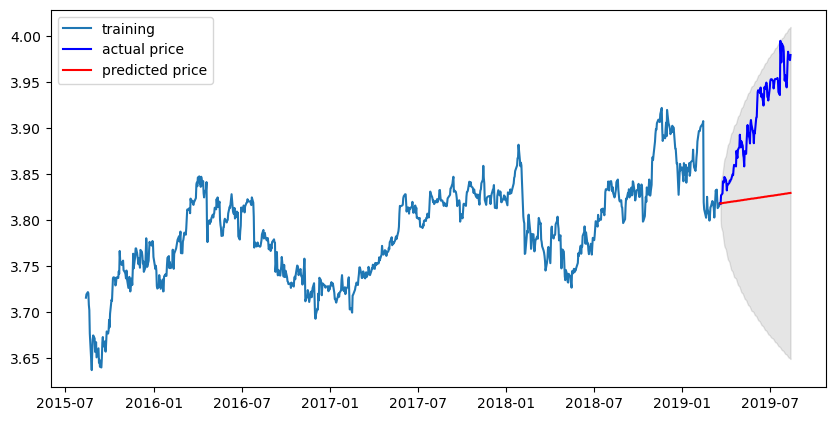

In [57]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index)
lw_price = pd.Series(conf[:, 0], index = test_data.index)
hg_price = pd.Series(conf[:, 1], index = test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lw_price.index, lw_price, hg_price, color='k', alpha=.10)
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse =mean_squared_error(np.exp(test_data),np.exp(fc), squared = False)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format((mape)*100))

MSE:  21.960556267433457
MAE:  4.120034694500501
RMSE:  4.686209157456958
MAPE: 8.06%


# MICROSOFT 주식 예측

In [59]:
dataset_path = os.getenv("HOME")+"/aiffel/stock_prediction/data/MSFT.csv"
df = pd.read_csv(dataset_path, index_col = 'Date', parse_dates = True)
ts = df['Close']

ts.head()


Date
2015-08-13    46.730000
2015-08-14    47.000000
2015-08-17    47.320000
2015-08-18    47.270000
2015-08-19    46.610001
Name: Close, dtype: float64

In [60]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [61]:
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.047655
p-value                           0.954409
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


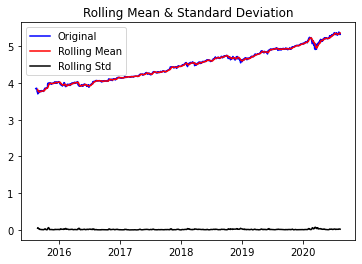

Results of Dickey-Fuller Test:
Test Statistic                   -0.047655
p-value                           0.954409
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


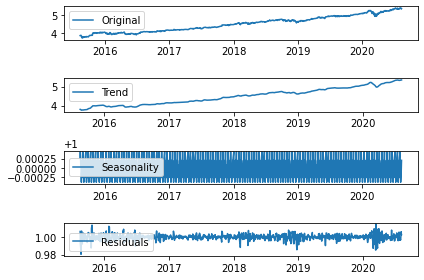

In [62]:
plot_rolling_statistics(ts_log, window=8)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,"multiplicative", period = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [63]:
# Residual 안정성 확인
residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.447416e+01
p-value                        6.531234e-27
#Lags Used                     1.400000e+01
Number of Observations Used    1.234000e+03
Critical Value (1%)           -3.435660e+00
Critical Value (5%)           -2.863885e+00
Critical Value (10%)          -2.568019e+00
dtype: float64


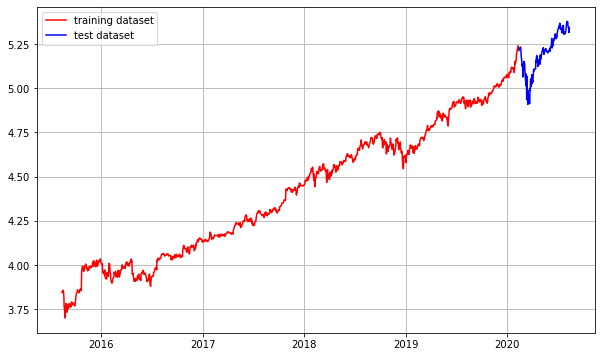

In [64]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')
plt.plot(test_data, c = 'b' ,label = 'test dataset')
plt.legend()

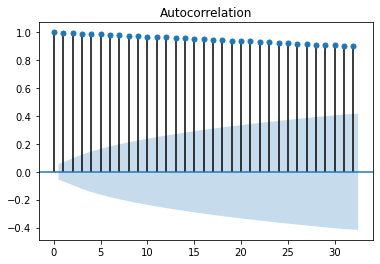

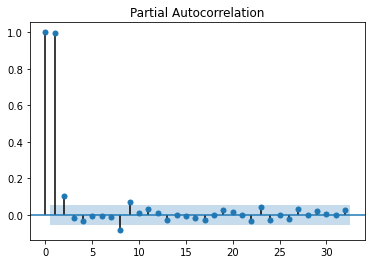

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.278154e+01
p-value                        7.397185e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


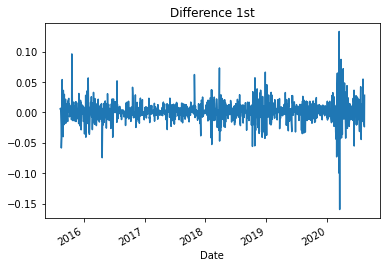

In [66]:
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.368877e+01
p-value                        1.356464e-25
#Lags Used                     1.900000e+01
Number of Observations Used    1.237000e+03
Critical Value (1%)           -3.435647e+00
Critical Value (5%)           -2.863879e+00
Critical Value (10%)          -2.568015e+00
dtype: float64


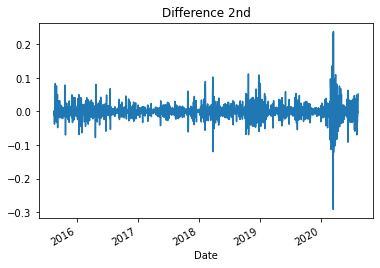

In [67]:
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [68]:
model = ARIMA(train_data, order = (1,0,0))
fit = model.fit(disp =-1)
print(fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1133
Model:                     ARMA(1, 0)   Log Likelihood                3192.881
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 13 Aug 2020   AIC                          -6379.762
Time:                        17:25:34   BIC                          -6364.664
Sample:                             0   HQIC                         -6374.059
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5160      0.590      7.652      0.000       3.359       5.673
ar.L1.Close     0.9997      0.000   2863.718      0.000       0.999       1.000
                                    Roots       

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


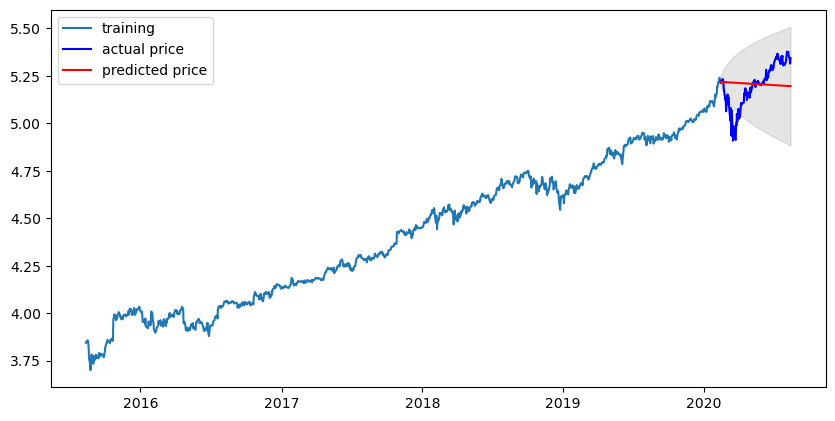

In [69]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index)
lw_price = pd.Series(conf[:, 0], index = test_data.index)
hg_price = pd.Series(conf[:, 1], index = test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lw_price.index, lw_price, hg_price, color='k', alpha=.10)
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse =mean_squared_error(np.exp(test_data),np.exp(fc), squared = False)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  462.5107461154918
MAE:  17.37333294169794
RMSE:  21.50606300826564
MAPE: 9.89%


# XOM 주가 예측

In [71]:
dataset_path = os.getenv("HOME")+"/aiffel/stock_prediction/data/XOM.csv"
df = pd.read_csv(dataset_path, index_col = 'Date', parse_dates = True)
ts = df['Close']
df.index = pd.DatetimeIndex(df.index).to_period('M')
ts.head()

Date
2015-06-15    83.720001
2015-06-16    84.680000
2015-06-17    84.730003
2015-06-18    85.480003
2015-06-19    85.209999
Name: Close, dtype: float64

In [72]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [73]:
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -3.077893
p-value                           0.028233
#Lags Used                        0.000000
Number of Observations Used    1036.000000
Critical Value (1%)              -3.436678
Critical Value (5%)              -2.864334
Critical Value (10%)             -2.568258
dtype: float64


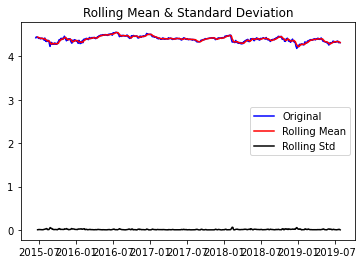

Results of Dickey-Fuller Test:
Test Statistic                   -3.077893
p-value                           0.028233
#Lags Used                        0.000000
Number of Observations Used    1036.000000
Critical Value (1%)              -3.436678
Critical Value (5%)              -2.864334
Critical Value (10%)             -2.568258
dtype: float64


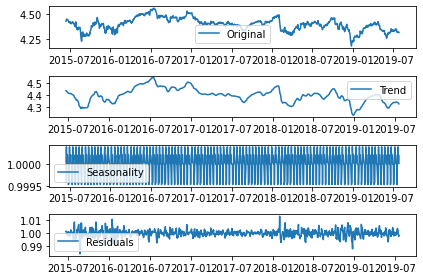

In [74]:
plot_rolling_statistics(ts_log, window=8)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,"multiplicative", period = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [75]:
# Residual 안정성 확인
residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.295929e+01
p-value                        3.250852e-24
#Lags Used                     1.700000e+01
Number of Observations Used    1.009000e+03
Critical Value (1%)           -3.436848e+00
Critical Value (5%)           -2.864409e+00
Critical Value (10%)          -2.568297e+00
dtype: float64


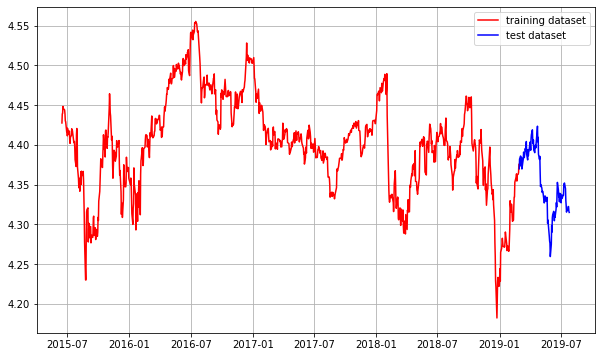

In [76]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')
plt.plot(test_data, c = 'b' ,label = 'test dataset')
plt.legend()

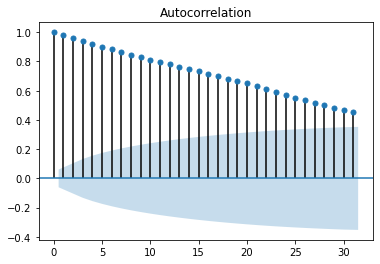

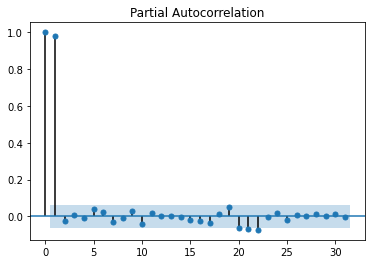

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.770748
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1035.000000
Critical Value (1%)              -3.436684
Critical Value (5%)              -2.864337
Critical Value (10%)             -2.568259
dtype: float64


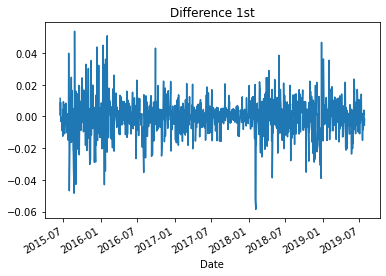

In [78]:
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.385092e+01
p-value                        7.007694e-26
#Lags Used                     1.900000e+01
Number of Observations Used    1.015000e+03
Critical Value (1%)           -3.436809e+00
Critical Value (5%)           -2.864392e+00
Critical Value (10%)          -2.568288e+00
dtype: float64


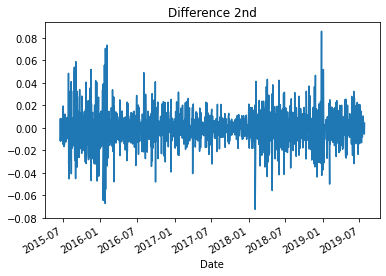

In [79]:
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [80]:
model = ARIMA(train_data, order = (1,1,0))
fit = model.fit(disp =-1)
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  932
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2773.907
Method:                       css-mle   S.D. of innovations              0.012
Date:                Thu, 13 Aug 2020   AIC                          -5541.814
Time:                        17:25:37   BIC                          -5527.302
Sample:                             1   HQIC                         -5536.279
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.545e-05      0.000     -0.135      0.893      -0.001       0.001
ar.L1.D.Close     0.0188      0.033      0.573      0.567      -0.045       0.083
                                    Root

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


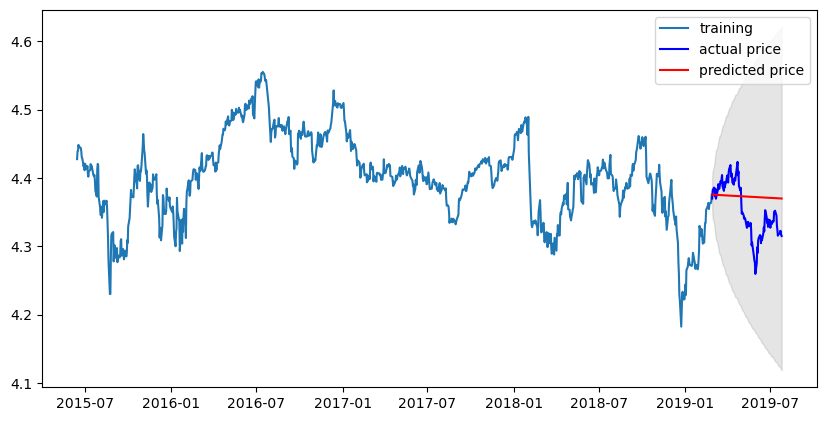

In [81]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index)
lw_price = pd.Series(conf[:, 0], index = test_data.index)
hg_price = pd.Series(conf[:, 1], index = test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lw_price.index, lw_price, hg_price, color='k', alpha=.10)
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse =mean_squared_error(np.exp(test_data),np.exp(fc), squared = False)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10.594348300249969
MAE:  2.7882265140874645
RMSE:  3.254896050605913
MAPE: 3.65%


# 코카콜라 주식 예측

In [83]:
dataset_path = os.getenv("HOME")+"/aiffel/stock_prediction/data/KO.csv"
df = pd.read_csv(dataset_path, index_col = 'Date', parse_dates = True)
ts = df['Close']
df.index = pd.DatetimeIndex(df.index).to_period('M')
ts.head()

Date
2015-08-13    41.099998
2015-08-14    41.250000
2015-08-17    41.349998
2015-08-18    41.299999
2015-08-19    40.779999
Name: Close, dtype: float64

In [84]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [85]:
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.379754
p-value                           0.591943
#Lags Used                        2.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


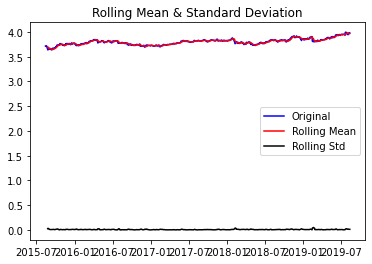

Results of Dickey-Fuller Test:
Test Statistic                   -1.379754
p-value                           0.591943
#Lags Used                        2.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


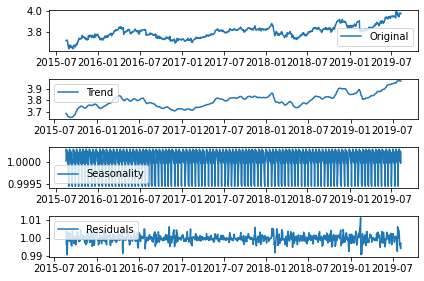

In [86]:
plot_rolling_statistics(ts_log, window=8)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,"multiplicative", period = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [87]:
# Residual 안정성 확인
residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.081085e+01
p-value                        1.910430e-19
#Lags Used                     2.200000e+01
Number of Observations Used    9.740000e+02
Critical Value (1%)           -3.437082e+00
Critical Value (5%)           -2.864512e+00
Critical Value (10%)          -2.568352e+00
dtype: float64


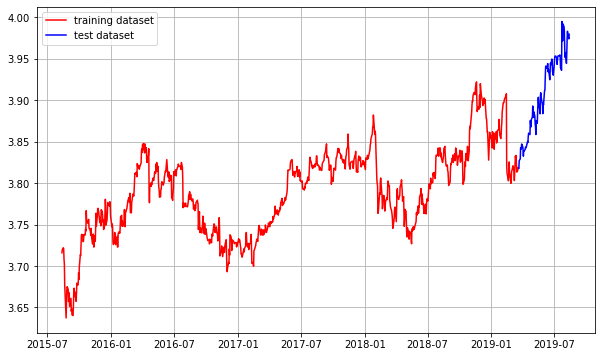

In [88]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')
plt.plot(test_data, c = 'b' ,label = 'test dataset')
plt.legend()

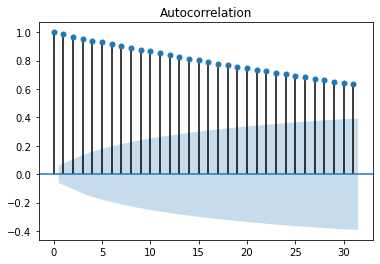

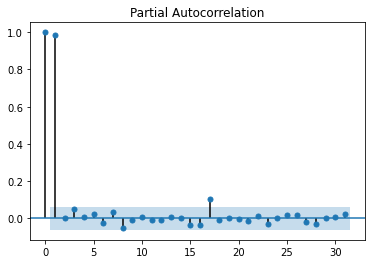

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.409868e+01
p-value                        2.642312e-26
#Lags Used                     5.000000e+00
Number of Observations Used    1.000000e+03
Critical Value (1%)           -3.436906e+00
Critical Value (5%)           -2.864435e+00
Critical Value (10%)          -2.568311e+00
dtype: float64


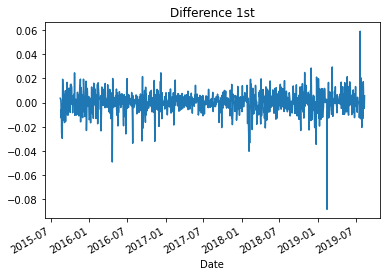

In [90]:
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.219881e+01
p-value                        1.236748e-22
#Lags Used                     2.100000e+01
Number of Observations Used    9.830000e+02
Critical Value (1%)           -3.437020e+00
Critical Value (5%)           -2.864485e+00
Critical Value (10%)          -2.568338e+00
dtype: float64


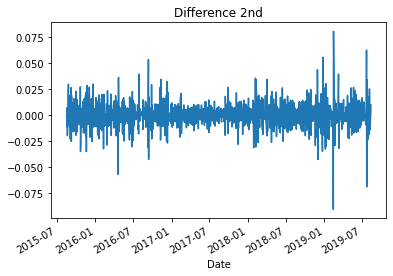

In [91]:
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [92]:
model = ARIMA(train_data, order = (1,1,0))
fit = model.fit(disp =-1)
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  905
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2966.704
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 13 Aug 2020   AIC                          -5927.409
Time:                        17:25:41   BIC                          -5912.985
Sample:                             1   HQIC                         -5921.900
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.372      0.710      -0.000       0.001
ar.L1.D.Close     0.0038      0.033      0.114      0.909      -0.061       0.069
                                    Root

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


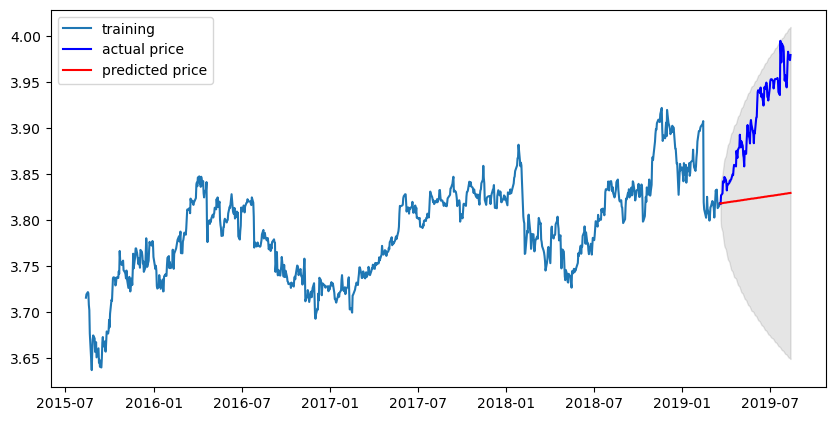

In [93]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index)
lw_price = pd.Series(conf[:, 0], index = test_data.index)
hg_price = pd.Series(conf[:, 1], index = test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lw_price.index, lw_price, hg_price, color='k', alpha=.10)
plt.legend()
plt.show()

In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse =mean_squared_error(np.exp(test_data),np.exp(fc), squared = False)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  21.960556267433457
MAE:  4.120034694500501
RMSE:  4.686209157456958
MAPE: 8.06%


### 경제학에서 주식을 바라볼때 보는 가설 중 하나는 효율적 시장가설이다. 효율적 시장가설이란 얻을 수 있는 모든 정보"(All available information)를 빠르게 반영하며 따라서 그 정보들을 이용하여 장기적으로 시장 수익률을 넘을 수 없다는 가설이다. 물론 행태경제학에서 인간은 비이성적이기 때문에 효율적 시장가설이 존재하지 않는다고 주장한다. 하지만 통계기법으로 다양한 노이즈가 존재하는 경제 데이터를 예측하는 건 불가능에 가깝다. 통계는 COVID-19라는 전무후무한 병균의 존재를 예측할 수 없으며 트럼프와 시진핑간의 미중무역전쟁 또한 예측불가능하다. 여기서 예측율을 높이고 편차를 줄이는 방법은 최대한 안정적으로 유지하는 데이터를 가져오고 여러 변수를 제거하는 것이다. 그래서 가져온 데이터는 2008년 글로벌 금융위기의 영향을 받지 않아야 하며  COVID-19의 영향도 제거해야 한다. 그렇기에 나는 2015년~2016년를 시작하고 2019년 8월까지의 데이터를 추출했다. 이러한 제한된 환경에서는 주식 예측은 성공적이었다. 그러나 일반적인 환경에서는 예측오차에서 벗어날 확률은 20%중후반을 형성되어 있다. 

## 결론 : 경제 상황이 안정적일때 사용할 수 있으나 경제 상황은 안정적이라는 것을 담보할 수 없다.